# DATSCIW261 ASSIGNMENT #2
MIDS UC Berkeley, Machine Learning at Scale  
DATSCIW261 ASSIGNMENT #2  
[Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)  
23 Jan 2016

## INSTRUCTIONS for SUBMISSIONS
Follow the instructions for submissions carefully.

Submit your homework via the following form by  8:00AM of the following Tuesday (West Coast Time):

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 

## Week 2 ASSIGNMENTS using Hadoop Streaming and Python

### HW2.0.  
1. What is a race condition in the context of parallel computation? Give an example.
1. What is MapReduce?
1. How does it differ from Hadoop?
1. Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

**Answers**:
1. A race condition is where concurrent work units access the same resource in ways that violate its invariants.  For a simple example, consider two threads are incrementing the same number in memory: they will each read its value, increment it in a register, and write it back.  If they do not coordinate (synchronize) to avoid interleaving their operations, a future reader can see (indeterminately) either the effect of one or both increments.  For things with more complicated state than a number, much more complicated failures and inconsistencies are possible.
2. MapReduce is a programming model aimed at simplifying writing a class of data parallel programs (viz. dataflow graphs are DAGs), based on a proprietary Google system described in Dean and Ghemawat's MapReduce paper. The key contribution is the idea that the framework should handle fault tolerance, distributed sorting, and work distribution.
3. Hadoop is a Java-based implementation of MapReduce, plus its necessary infrastructure and ecosystem: shared, redundant FS HDFS; resource manager YARN; etc.
4. The programming paradigm is broadly functional, with the map and reduce corresponding to FP maps and folds, and the framework's assumption that mappers and reducers are sufficiently side-effect free that they can be run in principle wherever their input datasets reside, and only their outputs need to be passed to subsequent computations.

In [1]:
# 2.0.4 pt 2: Example of functional programming
from functools import reduce
# I put these in temporaries just to print.
# The domains and ranges for each operation match 
# to permit function composition
val=range(1,20,2); print val
val=map(lambda x: 2*x, val); print val
val=filter(lambda x: x%5 != 0, val); print val
val=reduce(lambda x,y:x+y, val); print val

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
[2, 6, 10, 14, 18, 22, 26, 30, 34, 38]
[2, 6, 14, 18, 22, 26, 34, 38]
160


### HW2.1. Sort in Hadoop MapReduce
1. Given as input: Records of the form &lt;integer, “NA”>, where integer is any integer, and “NA” is just the empty string.  
Output: sorted key value pairs of the form &lt;integer, “NA”> in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.
2. Write code to generate N  random records of the form &lt;integer, “NA”>.   Let N = 10,000.  
3. Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

1. Keys are generally mapped to partitions (which are sent to reducers) using hashing, c.f.
https://hadoop.apache.org/docs/r2.6.3/api/src-html/org/apache/hadoop/mapreduce/lib/partition/KeyFieldBasedPartitioner.html#line.116
However, each partition is sorted before the reducer receives it.
To sort the whole colelction, each reducers' outputs would need to be merged.  
Alternatively, the key space could be partitioned using an order-preserving function so that the reducers receive nonoverlapping key ranges.  In that case, the outputs could simply be concatenated to produce a fully sorted list. TeraSort uses a version of this approach by sampling the data to estimate the distribution to identify split points for each partition. Here we might do something similar by sampling the file, generating an ordering to file, and using `InputSampler.RandomSampler` with `TotalOrderPartitioner`.

In [216]:
# 2.1.2: Generate N random number records.
import numpy as np
import sys
from __future__ import print_function
from pprint import pprint
def genRecs(n):
    return np.random.randint(sys.maxsize, size=n)
vals=map(lambda x: '<{0},>'.format(x), genRecs(10))
pprint(vals)
with open('hw2.1.2-input.txt','w') as f:
    map(lambda x: print('<{0},>'.format(x), file=f), genRecs(10000))

['<7715838003323725474,>',
 '<8927907652459930346,>',
 '<926607687554684540,>',
 '<7680516555178544267,>',
 '<7944385424105986080,>',
 '<5395785193502080406,>',
 '<4046030754868128474,>',
 '<5533272548239392713,>',
 '<3182765034109757362,>',
 '<2261489640275662849,>']


In [217]:
!wc -l hw2.1.2-input.txt

10000 hw2.1.2-input.txt


In [218]:
# 2.1.3: write map reduce job to sort

In [219]:
%%writefile hw2.1.2-mapper.py
#!/usr/bin/env python
import re
import sys
recfm=re.compile(r'<(\d+),(.*)>')
for rec in sys.stdin:
    (key, val)=recfm.match(rec).groups()
    # intermediate format of TSV is most conducive to using Hadoop built-in classes.
    print('{0}\t{1}'.format(key,val))
sys.exit(0)

Writing hw2.1.2-mapper.py


In [220]:
# test it in shell
!chmod +x hw2.1.2-mapper.py
!head -5 hw2.1.2-input.txt | ./hw2.1.2-mapper.py

3870687764995115412	
7860869446832126138	
7523109932569438676	
8424217397570237330	
730824256601886477	


In [221]:
%%writefile hw2.1.2-reducer.py
#!/usr/bin/env python
import re
import sys
recfm=re.compile(r'(\d+)\t(.*)')
for rec in sys.stdin:
    (key, val)=recfm.match(rec).groups()
    # restore the input format
    print('<{0},{1}>'.format(key,val))
sys.exit(0)

Writing hw2.1.2-reducer.py


In [222]:
# test in shell
!chmod +x hw2.1.2-reducer.py
!head -5 hw2.1.2-input.txt | \
 python hw2.1.2-mapper.py | \
 sort -nk1 -t, | \
 python hw2.1.2-reducer.py

<730824256601886477,>
<3870687764995115412,>
<7523109932569438676,>
<7860869446832126138,>
<8424217397570237330,>


In [223]:
!rm -fr hw2.1.2-output
import os
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_ROOT_LOGGER']='WARN,DRFA'
os.environ['HADOOP_HOME']=hh
os.environ['PATH']+=':{0}/bin'.format(hh)
# Here we set the key comparator to KeyFieldBasedComparator so we can compare
# keys numerically
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator  \
 -D mapreduce.job.text.key.comparator.options=-k1,1n \
 -D mapreduce.partition.keycomparator.options=-k1,1n \
 -mapper $PWD/hw2.1.2-mapper.py \
 -reducer $PWD/hw2.1.2-reducer.py \
 -input file://$PWD/hw2.1.2-input.txt \
 -output file://$PWD/hw2.1.2-output \
 -numReduceTasks 5

packageJobJar: [/tmp/hadoop-unjar2067734728266591533/] [] /tmp/streamjob6901630314726761557.jar tmpDir=null


In [224]:
%%bash 
cd hw2.1.2-output
pwd
for fn in p*; do 
  # show the range of keys in each file
  echo "$fn:  $(head -1 $fn)  $(tail -n 1 $fn)"
done

/media/sf_berkeley/w261/hw/week2/hw2.1.2-output
part-00000:  <13280685273349715,>	  <9213393252186323997,>	
part-00001:  <3222714103870687,>	  <9221118439061249770,>	
part-00002:  <1071092812250789,>	  <9222624263153999277,>	
part-00003:  <336245050853835,>	  <9221148113448026408,>	
part-00004:  <1161423271932505,>	  <9215727606559301466,>	


Note that the files are sorted, and that they cover overlapping key  ranges and.  
Below I try again using some arbitrary (evenly spaced, rather than equally weighted) split points in the data range with a custom `Partitioner`

In [535]:
%%writefile MyPartitioner.scala
import org.apache.hadoop.mapred._
import org.apache.hadoop.io._
import scala.collection.immutable.Range

class MyPartitioner extends Partitioner[Text,Text] {
    override def configure(job: JobConf) = {}
    override def getPartition(key: Text, value: Text, numPartitions: Int): Int = {
        if(numPartitions==1) {
            return(0)
        }
        val num=key.toString.toLong
        // partition [Long.MinValue,Long.MaxValue] into numPartitions pieces
        val step: Long = 2*(Long.MaxValue/numPartitions)
        for(n <- 1 to numPartitions) {
            if (num < (Long.MinValue + n*step)) {
                return(n-1)
            }
        }
        // We arrive here if there was a remainder calculating `step`.
        // Ordering requies we return the final partition ID.
        return(numPartitions-1)
      }
}

Overwriting MyPartitioner.scala


In [534]:
# build and package the class and related files
!scalac -classpath `hadoop classpath` MyPartitioner.scala
!rm -f MyPartitioner.jar
!jar -cf MyPartitioner.jar MyPartitioner*.class

In [225]:
!rm -fr hw2.1.2-output
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_HOME']=hh
os.environ['HADOOP_CLASSPATH']=os.environ['PWD']+'/MyPartitioner.jar:/usr/share/scala/lib/scala-library.jar'
os.environ['PATH']+=':{0}/bin'.format(hh)
!hdfs dfs -put -f _partitions.lst .
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -libjars MyPartitioner.jar,/usr/share/scala/lib/scala-library.jar \
 -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
 -D mapreduce.partition.keycomparator.options=-k1,1n \
 -partitioner MyPartitioner \
 -mapper $PWD/hw2.1.2-mapper.py \
 -reducer $PWD/hw2.1.2-reducer.py \
 -input file://$PWD/hw2.1.2-input.txt \
 -output file://$PWD/hw2.1.2-output \
 -numReduceTasks 2

packageJobJar: [/tmp/hadoop-unjar2985831871742788506/] [] /tmp/streamjob358739699413448177.jar tmpDir=null


In [226]:
%%bash 
cd hw2.1.2-output
pwd
for fn in p*; do 
  echo "$fn:  $(head -1 $fn)  $(tail -n 1 $fn)"
done
wc -l p*

/media/sf_berkeley/w261/hw/week2/hw2.1.2-output
part-00000:  <336245050853835,>	  <4611373162031975932,>	
part-00001:  <4614974572471885836,>	  <9222624263153999277,>	
  4979 part-00000
  5021 part-00001
 10000 total


In [227]:
!echo Bottom 10
!head -10 /media/sf_berkeley/w261/hw/week2/hw2.1.2-output/part-00000
!echo;echo Top 10
!tail -10 /media/sf_berkeley/w261/hw/week2/hw2.1.2-output/part-00001

Bottom 10
<336245050853835,>	
<1071092812250789,>	
<1161423271932505,>	
<3119770612557037,>	
<3222714103870687,>	
<6540983618169749,>	
<7672790645226854,>	
<10375098727484635,>	
<12856882285734868,>	
<13280685273349715,>	

Top 10
<9210905088526305630,>	
<9211328889854513548,>	
<9212832503963111733,>	
<9213393252186323997,>	
<9213514714737628610,>	
<9215727606559301466,>	
<9221118439061249770,>	
<9221148113448026408,>	
<9222151012737340093,>	
<9222624263153999277,>	


Now the parts no longer overlap, and look nicely sorted.

### HW2.2.  WORDCOUNT
Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

 
CROSSCHECK:
````bash 
grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
8    
````
**NOTE**: "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!

In [228]:
%%writefile hw2.2-mapper.py
#!/opt/anaconda/bin/python
import re
import sys
# white-space delimitted token (assume spaces, fullstops, comma as delimiters)
ws_re=re.compile(r'[ ,.]+')
for line in sys.stdin:
    fields=line.strip().split('\t')
    for field in fields[2:]:
        if field=='NA':
            continue
        for word in ws_re.split(field):
            if word:
                print('{0}\t1'.format(word.lower()))
exit(0)

Writing hw2.2-mapper.py


In [229]:
%%writefile hw2.2-reducer.py
#!/opt/anaconda/bin/python
import re
import sys

current=''
for line in sys.stdin:
    fields=line.strip().split('\t')
    if fields[0]!=current:
        if current:
            print '{0}\t{1}'.format(current, count)
        current=fields[0]
        count=0
    for field in fields[1:]:
        try:
            count += int(field)
        except Exception:
            pass
if count and current:
    print '{0}\t{1}'.format(current, count)
exit(0)

Writing hw2.2-reducer.py


In [230]:
!chmod +x hw2.2-mapper.py hw2.2-reducer.py
!head -2 enronemail_1h.txt | ./hw2.2-mapper.py | sort | ./hw2.2-reducer.py

christmas	1
farm	1
pictures	1
rankings	1
re:	1
thank	1
tree	1
you	1


In [231]:
!rm -fr hw2.2-output
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_ROOT_LOGGER']='WARN,DRFA'
os.environ['HADOOP_HOME']=hh
os.environ['PATH']+=':{0}/bin'.format(hh)
!hdfs dfs -put -f _partitions.lst .
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -mapper $PWD/hw2.2-mapper.py \
 -reducer $PWD/hw2.2-reducer.py \
 -input file://$PWD/enronemail_1h.txt \
 -output file://$PWD/hw2.2-output

packageJobJar: [/tmp/hadoop-unjar6461975994383565167/] [] /tmp/streamjob1076855424070321881.jar tmpDir=null


In [232]:
!grep assistance hw2.2-output/*

hw2.2-output/part-00000:assistance	9


### HW2.2.1
Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

In [250]:
%%writefile hw2.2.1-mapper.py
#!/opt/anaconda/bin/python
import sys
# swap key and value
for line in sys.stdin:
    print '\t'.join(reversed(line.strip().split('\t')))
exit(0)

Overwriting hw2.2.1-mapper.py


In [251]:
!chmod +x hw2.2.1-mapper.py
!head hw2.2-output/part-00000 | ./hw2.2.1-mapper.py

19	
2	)
1	!!
258	"
1	"'bcli
1	"'benewm
1	"'bjeffrie
1	"'blong
1	"'bredd
1	"'celias


In [258]:
!rm -fr hw2.2.1-output
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_ROOT_LOGGER']='WARN,console'
os.environ['HADOOP_CLASSPATH']=os.environ['PWD']+'/MyPartitioner.jar:/usr/share/scala/lib/scala-library.jar'
os.environ['HADOOP_HOME']=hh
os.environ['PATH']+=':{0}/bin'.format(hh)
!hdfs dfs -put -f _partitions.lst .
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -libjars MyPartitioner.jar,/usr/share/scala/lib/scala-library.jar \
 -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
 -D mapreduce.partition.keycomparator.options=-k1,1n \
 -partitioner MyPartitioner \
 -mapper $PWD/hw2.2.1-mapper.py \
 -reducer org.apache.hadoop.mapred.lib.IdentityReducer \
 -input file://$PWD/hw2.2-output/part-00000 \
 -output file://$PWD/hw2.2.1-output \
 -numReduceTasks 5

packageJobJar: [/tmp/hadoop-unjar3814726418635240158/] [] /tmp/streamjob9177026242710030947.jar tmpDir=null


In [260]:
%%bash 
cd hw2.2.1-output
pwd
for fn in p*; do 
  echo "$fn:  $(head -1 $fn)  $(tail -n 1 $fn)"
done
wc -l p*
echo Top Ten Words:
tail -10 part-00000 | sort -nrk1

/media/sf_berkeley/w261/hw/week2/hw2.2.1-output
part-00000:  1	readers'mind  1223	the
part-00001:    
part-00002:    
part-00003:    
part-00004:    
 6375 part-00000
    0 part-00001
    0 part-00002
    0 part-00003
    0 part-00004
 6375 total
Top Ten Words:
1223	the
903	to
648	and
547	of
524	a
408	in
401	you
382	your
361	for
361	@


### HW2.3. Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that \\
will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the $\Pr\left(X=\mathrm{“assistance”}\vert Y=\mathrm{SPAM}\right)$ is calculated as follows:

$$ \frac{\mbox{the number of times “assistance” occurs in SPAM labeled documents}}{\mbox{the number of words in documents labeled SPAM}}$$

E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then $\Pr\left(X=\mathrm{“assistance”}\vert Y=\mathrm{SPAM}\right) = \frac{5}{1000}$. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since $\log(xy) = \log(x) + \log(y)$, it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 

Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., $\Pr(Class|Doc)$) for each class over the training set. Summarize what you see. 

Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let $DF$ represent the evalution set in the following and $c(X)$ the class of document $X$:
$$ \mathrm{Err}(\mathrm{Model}, DF) = \frac{\left\lvert \left\lbrace(X, c(X)) \in DF : c(X) \neq \mathrm{Model}(x)\right\rbrace\right\rvert}{\lvert DF\rvert}$$

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”

In [281]:
%%writefile hw2.3-mapper.py
#!/opt/anaconda/bin/python
from collections import Counter
import itertools
import re
import sys

strip_re=re.compile(r'\W+')
split_re=re.compile(r'''(?:\s|\.|[-/:,' "@\|+*]|\\)+''')
def tokenize(*fields):
    for field in fields:
        if field.strip() != 'NA':
            # expand certain contractions
            field=re.sub(r"'ll\b", " will", field)
            field=re.sub(r"n't\b", " not", field)
            field=re.sub(r"'re\b", " are", field)
            field=re.sub(r"\bit's\b", "it is", field)
            for word in split_re.split(field.lower()):
                word=strip_re.sub('', word)
                if word:
                    yield word

def main():
    for linenum, line in enumerate(sys.stdin):
        fields=line.split('\t')
        if len(fields) != 4:
            print >>sys.stderr, "Skipping line {0}: expected 4 fields, found {1}".format(linenum, len(fields))
            continue
        docid=fields[0]
        classid=('spam' if fields[1] == '1' else 'ham')
        words=Counter(tokenize(fields[2], fields[3]))
        print 'doc {0} {1} {2}'.format(docid, classid, sum(words.values()))
        for word, count in words.items():
            print 'term {0} {1} {2} {3}'.format(docid, classid, word, count)

if __name__ == '__main__':
    main()

Overwriting hw2.3-mapper.py


In [540]:
%%writefile hw2.3-reducer.py
#!/opt/anaconda/bin/python
from collections import namedtuple, defaultdict, Counter
import itertools
import math
import os
import sys

class NBClassifier(object):
    """Class to consume output of mapper.py to train a multinomial
    naive Bayes classifier, and to predict classes.
    """
    # little helper types to refer to mapper output fields by name instead of position
    DocRecord=namedtuple("DocRecord",['docid', 'classid', 'count'])
    TermRecord=namedtuple("TermRecord",['docid', 'classid', 'term', 'count'])

    def __init__(self, alpha=0.0, floor=None):
        """Create a naive bayes classifier instance with the specified smoothing:
        0 for no smoothing
        1 for Laplace smoothing
        Any other value for Lidstone smoothing
        """
        self.alpha=alpha    # smoothing param
        self.verbose=False  # debug logging flag
        self.floor=floor    # min DF filter
        self.class_counts=Counter() # count of each class for calculating priors
        self.doc_classes={} # count of each class for calculating priors
        self.doc_term_counts=defaultdict(lambda:defaultdict(lambda:0)) # bags of words for documents
        self.class_term_counts=defaultdict(lambda:Counter()) # for cond prob numerators
        self.class_tot_counts=Counter() # for cond prob denominators
        self.class_priors=None # computed priors
        self.cond_probs=None   # computed cond. probs
        self.zeros=0           # count of zero probailities/docs having terms not in a class
        self.floor_omitted=0   # count of terms occurring fewer than `floor` times
        
    def fit(self, iterable):
        """Consume mapper records and calculate probabilities"""
        for line in iterable:
            self._add_rec(line)
        self._calc_priors()
        self._calc_cond_probs()
    def predict_proba(self, doc_term_counts):
        """Return class posterior probs of a list of term counts"""
        posteriors={}
        used={}
        # start with the prior (log) probs for each class
        for classid, prior in self.class_priors.items():
            posteriors[classid]=prior
        # then for each class
        for classid, denom in self.class_tot_counts.items():
            try:
                for term, doc_count in doc_term_counts.items():
                    # combine each term's (log) cond. prob contribution
                    n_terms=len(self.class_term_counts[classid])
                    term_count=self.class_term_counts[classid][term]
                    cond_prob=math.log(term_count+self.alpha)-math.log(denom+self.alpha*n_terms)
                    posteriors[classid]+=doc_count*cond_prob
            except ValueError:
                # tried to take log(0)
                self.zeros+=1
                posteriors[classid]=float('-inf')
                if self.verbose:
                    print '{0} not present in class {1} term list'.format(term, classid)
                pass
        return posteriors
    
    def predict(self, doc_term_counts):
        """Return class ID maximizing posterior prob of a list of term counts"""
        posteriors=self.predict_proba(doc_term_counts)
        return max(posteriors, key=lambda x: posteriors[x])

    
    def _add_rec(self, line):
        """Consume mapper-produced doc and term records"""
        try:
            args=line.strip().split()
            if args[0]=='doc':
                if self.verbose:
                    print >>sys.stderr,"Processing doc", args[1]
                rec=NBClassifier.DocRecord(args[1], args[2], int(args[3]))
                self.doc_classes[rec.docid]=rec.classid
                self.class_counts[rec.classid]+=1
            elif args[0]=='term':
                rec=NBClassifier.TermRecord(args[1], args[2], args[3], float(args[4]))
                self.class_term_counts[rec.classid][rec.term]+=rec.count
                self.class_tot_counts[rec.classid]+=rec.count
                self.doc_term_counts[rec.docid][rec.term]+=rec.count
            else:
                print >>sys.stderr, 'Unexpected row: {0}'.format(line)
        except ValueError, n:
            print >>sys.stderr, line
            raise n
    def _calc_priors(self):
        """Calculate log prior probs for a doc to be in each class"""
        doc_count=sum(self.class_counts.values())
        self.class_priors=defaultdict(lambda:0)
        for classid, count in self.class_counts.items():
            self.class_priors[classid]=math.log(1.0*count/doc_count)

    def _calc_cond_probs(self):
        self.cond_probs=defaultdict(lambda:defaultdict(lambda:0))
        for classid, denom in self.class_tot_counts.items():
            n_terms=len(self.class_term_counts[classid])
            for term, count in self.class_term_counts[classid].items():
                if self.floor < count:
                    self.cond_probs[classid][term]=math.log(count+self.alpha)-math.log(denom+self.alpha*n_terms)
                else:
                    self.floor_omitted+=1

def main():
    alpha=os.environ.get('alpha',0.0)
    if isinstance(alpha, basestring):
        try:
            alpha=float(alpha)
        except:
            print >>sys.stderr,"Unable to parse alpha; disabling smoothing"
            alpha=0.0
    floor=os.environ.get('floor','0')
    try:
        floor=int(floor)
    except:
        print >>sys.stderr,"Unable to parse floor; disabling threshold"
        floor=0
    nbc=NBClassifier(alpha=alpha, floor=floor)
    nbc.fit(sys.stdin)
    nbc.verbose='verbose' in os.environ
    
    print >>sys.stderr, "Processed {0} records".format(len(nbc.doc_classes))
    print >>sys.stderr, "Classes:"
    for classid in nbc.class_counts:
        print >>sys.stderr, "    {0: <4.4s}: {1} terms, {2} docs, {3:.3f} prior".format(
            classid,
            len(nbc.cond_probs[classid]),
            nbc.class_counts[classid],
            nbc.class_priors[classid],
        )
        if nbc.verbose:
            for term, cond in itertools.islice(sorted(nbc.cond_probs[classid].items(),key=lambda x: -x[1]),10):
                print >>sys.stderr, "        {0}:\t{1}".format(term, cond)
    
    preds=[]
    matches=[]
    probs=[]
    for docid, actual in nbc.doc_classes.items():
        posteriors=nbc.predict_proba(nbc.doc_term_counts[docid])
        probs.append(posteriors)
        pred=max(posteriors, key=lambda x: posteriors[x])
        preds.append(pred)
        matches.append(pred==actual)
        s='{0}\t{1:d}\t{2:d}'.format(docid, actual=='spam', pred=='spam')
        for key in sorted(nbc.class_priors):
            s+='\t{0:.3f}'.format(posteriors[key])

        print s
        if nbc.verbose:
            posteriors=nbc.predict_proba(nbc.doc_term_counts[docid])
            print >>sys.stderr, '{0: <20.20s}  pred: {1: <4.4}  match: {2:1d}  {3}'.format(
                docid, pred, matches[-1],
            ', '.join('{0}: {1:.2f}'.format(k,v) for k,v in posteriors.items()))
    print >>sys.stderr, "Matches:",sum(matches),'of',len(matches)
    print >>sys.stderr, "Accuracy:",1.0*sum(matches)/len(matches)
    counts=defaultdict(lambda:0.0)
    for pred, match in zip(preds, matches):
        tag=''
        if match:
            tag += 't'
        else:
            tag += 'f'
        if pred=='spam':
            tag += 'p'
        else:
            tag += 'n'
        counts[tag] += 1
    for k,v in counts.items():
        print >>sys.stderr, "{0}: {1}".format(k,v)
    if counts['tp']+counts['fp'] > 0:
        print >>sys.stderr, "Precision: {0:.3f}".format(
            counts['tp']/(counts['tp']+counts['fp']))
    if counts['tp']+counts['fn'] > 0:
        print >>sys.stderr, "Recall:    {0:<.3f}".format(
            counts['tp']/(counts['tp']+counts['fn']))
    print >>sys.stderr, "Using alpha={0}, floor={1}".format(alpha, floor)
    print >>sys.stderr, "Omitted {0} terms due to floor".format(nbc.floor_omitted)
    print >>sys.stderr, "A document had terms missing from a class {0} times".format(nbc.zeros)

if __name__ == '__main__':
    main()

Overwriting hw2.3-reducer.py


In [545]:
%%bash
chmod +x hw2.3-mapper.py hw2.3-reducer.py
export alpha=0
cat enronemail_1h.txt | ./hw2.3-mapper.py | ./hw2.3-reducer.py > tmp.out

Skipping line 3: expected 4 fields, found 3
Skipping line 49: expected 4 fields, found 3
Skipping line 59: expected 4 fields, found 1
Processed 98 records
Classes:
    ham : 2662 terms, 55 docs, -0.578 prior
    spam: 3708 terms, 43 docs, -0.824 prior
Matches: 98 of 98
Accuracy: 1.0
tn: 55.0
tp: 43.0
Precision: 1.000
Recall:    1.000
Using alpha=0.0, floor=0
Omitted 0 terms due to floor
A document had terms missing from a class 98 times


In [458]:
!rm -fr hw2.3-output
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_ROOT_LOGGER']='WARN,console'
os.environ['HADOOP_CLASSPATH']=os.environ['PWD']+'/MyPartitioner.jar:/usr/share/scala/lib/scala-library.jar'
os.environ['HADOOP_HOME']=hh
os.environ['PATH']+=':{0}/bin'.format(hh)
!hdfs dfs -put -f _partitions.lst .
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -mapper $PWD/hw2.3-mapper.py \
 -reducer  $PWD/hw2.3-reducer.py \
 -input file://$PWD/enronemail_1h.txt \
 -output file://$PWD/hw2.3-output \
 -numReduceTasks 1

packageJobJar: [/tmp/hadoop-unjar1299450808783705091/] [] /tmp/streamjob1225005500450488088.jar tmpDir=null


In [459]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_data(filename):
    data=pd.read_csv(filename, sep='\t',header=None)
    data.columns=['id','actual', 'pred', 'p_ham', 'p_spam']
    data.index=data[['id']]
    return data[['actual', 'pred', 'p_ham', 'p_spam']]
data=read_data('hw2.3-output/part-00000')

Error rate: 0.0


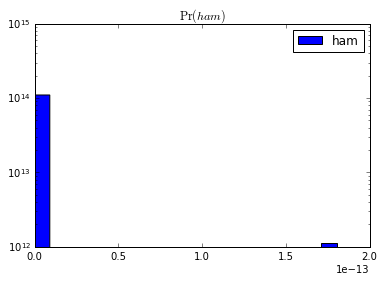

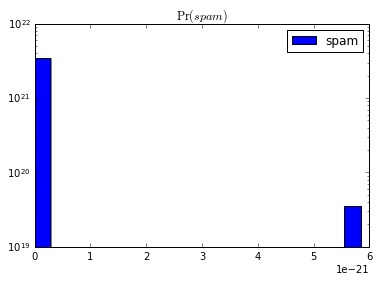

In [460]:
def plot(series,labels,cls):
    series=np.asarray(np.exp(series))
    plt.hist(series, bins=20, log=True,label=labels, normed=True)
    plt.title(r'$\Pr({0})$'.format(cls))
    plt.legend()
    plt.show()
print('Error rate: {0}'.format(1.0*sum(data['actual']!=data['pred'])/len(data)))
plot(data[['p_ham']], 'ham', 'ham')
plot(data[['p_spam']], 'spam', 'spam')

### HW2.4
Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

For a quick reference on the construction of the Multinomial NAIVE BAYES classifier that you will code,
please consult the "Document Classification" section of the following wikipedia page:

https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification

OR the original paper by the curators of the Enron email data:

http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf

In [461]:
!rm -fr hw2.4-output
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_ROOT_LOGGER']='WARN,console'
os.environ['HADOOP_CLASSPATH']=os.environ['PWD']+'/MyPartitioner.jar:/usr/share/scala/lib/scala-library.jar'
os.environ['HADOOP_HOME']=hh
os.environ['PATH']+=':{0}/bin'.format(hh)
!hdfs dfs -put -f _partitions.lst .
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -cmdenv alpha=1.0 \
 -mapper $PWD/hw2.3-mapper.py \
 -reducer  $PWD/hw2.3-reducer.py \
 -input file://$PWD/enronemail_1h.txt \
 -output file://$PWD/hw2.4-output \
 -numReduceTasks 1

packageJobJar: [/tmp/hadoop-unjar2914116536082364161/] [] /tmp/streamjob7403811963149859561.jar tmpDir=null


Error rate: 0.0


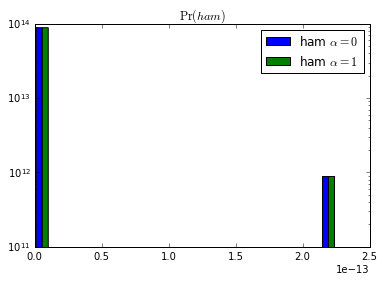

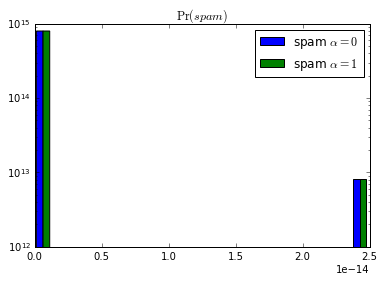

In [462]:
data2=data=read_data('hw2.4-output/part-00000')
print('Error rate: {0}'.format(1.0*sum(data2['actual']!=data2['pred'])/len(data2)))
plot(np.hstack((data[['p_ham']],data2[['p_ham']])), [r'ham $\alpha=0$', r'ham $\alpha=1$'], 'ham')
plot(np.hstack((data[['p_spam']],data2[['p_spam']])), [r'spam $\alpha=0$', r'spam $\alpha=1$'], 'spam')

The spam probabilities rose by several orders of magnitude, whereas the ham probabilities stayed closer. The counts look off since I set the `normed=True` parameter for the histogram.

### HW2.5.
Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset?

In [463]:
!rm -fr hw2.5-output
hh='/opt/hadoop-2.7.1'
os.environ['HADOOP_ROOT_LOGGER']='WARN,console'
os.environ['HADOOP_CLASSPATH']=os.environ['PWD']+'/MyPartitioner.jar:/usr/share/scala/lib/scala-library.jar'
os.environ['HADOOP_HOME']=hh
os.environ['PATH']+=':{0}/bin'.format(hh)
!hdfs dfs -put -f _partitions.lst .
!hadoop jar /opt/hadoop-2.7.1/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
 -cmdenv alpha=1.0 \
 -cmdenv floor=3 \
 -mapper $PWD/hw2.3-mapper.py \
 -reducer  $PWD/hw2.3-reducer.py \
 -input file://$PWD/enronemail_1h.txt \
 -output file://$PWD/hw2.5-output \
 -numReduceTasks 1

packageJobJar: [/tmp/hadoop-unjar3358820304963706168/] [] /tmp/streamjob4013402085016712401.jar tmpDir=null


Error rate: 0.0


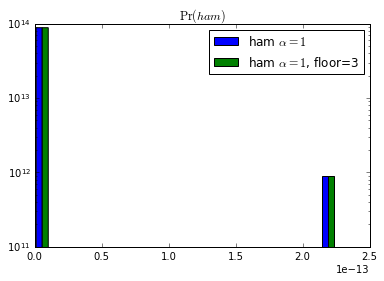

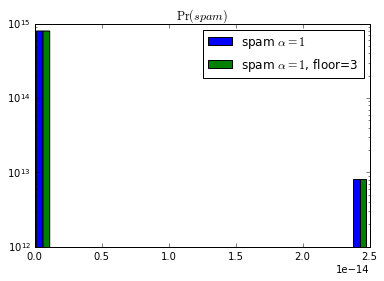

In [464]:
data3=data=read_data('hw2.5-output/part-00000')
print('Error rate: {0}'.format(1.0*sum(data3['actual']!=data3['pred'])/len(data3)))
plot(np.hstack((data2[['p_ham']],data3[['p_ham']])), [r'ham $\alpha=1$', r'ham $\alpha=1$, floor=3'], 'ham')
plot(np.hstack((data2[['p_spam']],data3[['p_spam']])), [r'spam $\alpha=1$', r'spam $\alpha=1$, floor=3'], 'spam')

### HW2.6
Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

In this exercise, please complete the following:

* Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
* Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
* Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

In [498]:
#recycle the tokenizer from 2.3
import re
strip_re=re.compile(r'\W+')
split_re=re.compile(r'''(?:\s|\.|[-/:,' "@\|+*]|\\)+''')
def tokenize(field):
    field=re.sub(r"'ll\b", " will", field)
    field=re.sub(r"n't\b", " not", field)
    field=re.sub(r"'re\b", " are", field)
    field=re.sub(r"\bit's\b", "it is", field)
    for word in split_re.split(field):
        word=strip_re.sub('', word)
        if word:
            yield word

In [499]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
pl=Pipeline([
        ('cv', CountVectorizer(tokenizer=tokenize)),
        ('nb', MultinomialNB())
    ])

In [571]:
def read_dataset():
    X=[]
    y=[]
    with open('enronemail_1h.txt') as f:
        for line in f:
            try:
                (docid,spam,subject,body)=line.strip().split('\t')
                line=''
                if subject!='NA':
                    line+=subject
                if body!='NA':
                    line+=body
                X.append(line)
                y.append(bool(spam=='1'))
            except ValueError,e:
                continue
    return np.asarray(X),np.asarray(y)

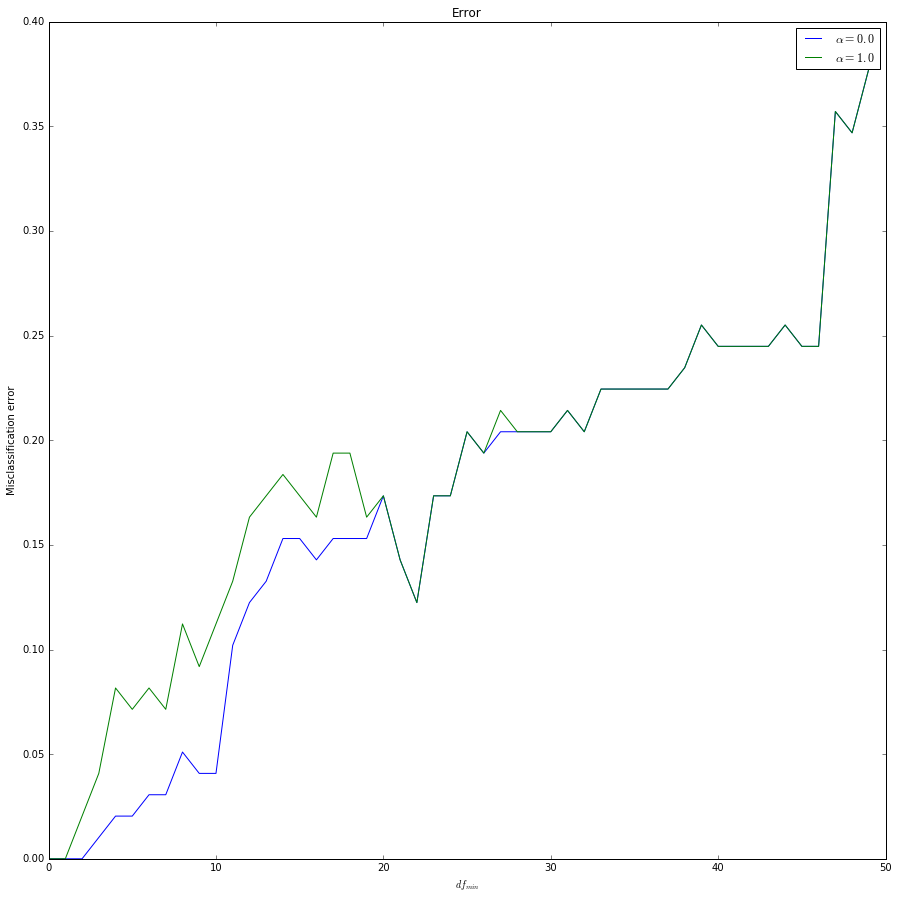

In [645]:
from sklearn.metrics import accuracy_score
def plot_errors():
    X,y = read_dataset()
    cv=pl.named_steps['cv']
    nb=pl.named_steps['nb']
    plt.figure(figsize=(15,15))
    for alpha in [0,1]:
        error=[]
        for df in range(0,50):
            nb.set_params(alpha=alpha)
            cv.set_params(min_df=df)
            tx=cv.fit_transform(X)
            nb.fit(tx, y)
            y_pred=nb.predict(tx)
            error.append(1-accuracy_score(y,y_pred))
        df=pd.DataFrame(np.asarray([error,range(0,50)]).T, columns=['error', 'df_min'])
        plt.plot(df[['df_min']],df[['error']],label=r'$\alpha={0:.1f}$'.format(alpha))
    plt.title('Error')
    plt.legend()
    plt.xlabel('$df_{min}$')
    plt.ylabel('Misclassification error')
    plt.show()
plot_errors()

We see that smoothing initially makes the effect of trimming infrequent words more pronounced. The error does not rise monotonically as the cutoff rises since some highly discriminating words may occur an intermediate number of times.  The plots converge once the cutoff/counts become high enough that smoothing fails to matter.

### HW 2.6.1 OPTIONAL (note this exercise is a stretch HW and optional)
* Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error 
* Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain. 

Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.

### HW2.7 OPTIONAL (note this exercise is a stretch HW and optional)

The Enron SPAM data in the following folder enron1-Training-Data-RAW is in raw text form (with subfolders for SPAM and HAM that contain raw email messages in the following form:

* Line 1 contains the subject
* The remaining lines contain the body of the email message.

In Python write a script to produce a TSV file called train-Enron-1.txt that has a similar format as the enronemail_1h.txt that you have been using so far. Please pay attend to funky characters and tabs. Check your resulting formated email data in Excel and in Python (e.g., count up the number of fields in each row; the number of SPAM mails and the number of HAM emails). Does each row correspond to an email record with four values? Note: use "NA" to denote empty field values.

### HW2.8 OPTIONAL
Using Hadoop Map-Reduce write job(s) to perform the following:
 
 * Train a multinomial Naive Bayes Classifier with Laplace plus one smoothing using the data extracted in HW2.7 (i.e., train-Enron-1.txt). Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Drop tokens with a frequency of less than three (3).
 * Test the learnt classifier using enronemail_1h.txt and report the misclassification error rate. Remember to use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). How do we treat tokens in the test set that do not appear in the training set?

### HW2.8.1 OPTIONAL
* Run  both the Multinomial Naive Bayes and the Bernoulli Naive Bayes algorithms from SciKit-Learn (using default settings) over the same training data used in HW2.8 and report the misclassification error on both the training set and the testing set
* Prepare a table to present your results, where rows correspond to approach used (SciKit-Learn Multinomial NB; SciKit-Learn Bernouili NB; Your Hadoop implementation)  and the columns presents the training misclassification error, and the misclassification error on the test data set
* Discuss the performance differences in terms of misclassification error rates over the test and training datasets by the different implementations. Which approch (Bernouili versus Multinomial) would you recommend for SPAM detection? Justify your selection.

~~~~  
END OF HOMEWORK